Kelompok 25 - LV01:
1. Alves Renato Sennellius - 2602130666
2. Howen Antonio - 2602123622

Parameter:
1. Epochs = 100
2. Batch Size = 32
3. Optimizer = Adam
4. Learning Rate = 0.00001
5. Loss Function = sparse_categorical_crossentropy
6. Total Parameters = 69,924,952 
7. Trainable Parameters = 57,222,672
8. Non-trainable Parameters = 12,702,280

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 300
colors = ["#B6EE56", "#D85F9C", "#EEA756", "#56EEE8"]

A search has been initiated within the folder named 'Dataset'.
There are 3200 images in the Non_Demented folder.
There are 896 images in the Mild_Demented folder.
There are 64 images in the Moderate_Demented folder.
There are 2240 images in the Very_Mild_Demented folder.
The search has been completed.


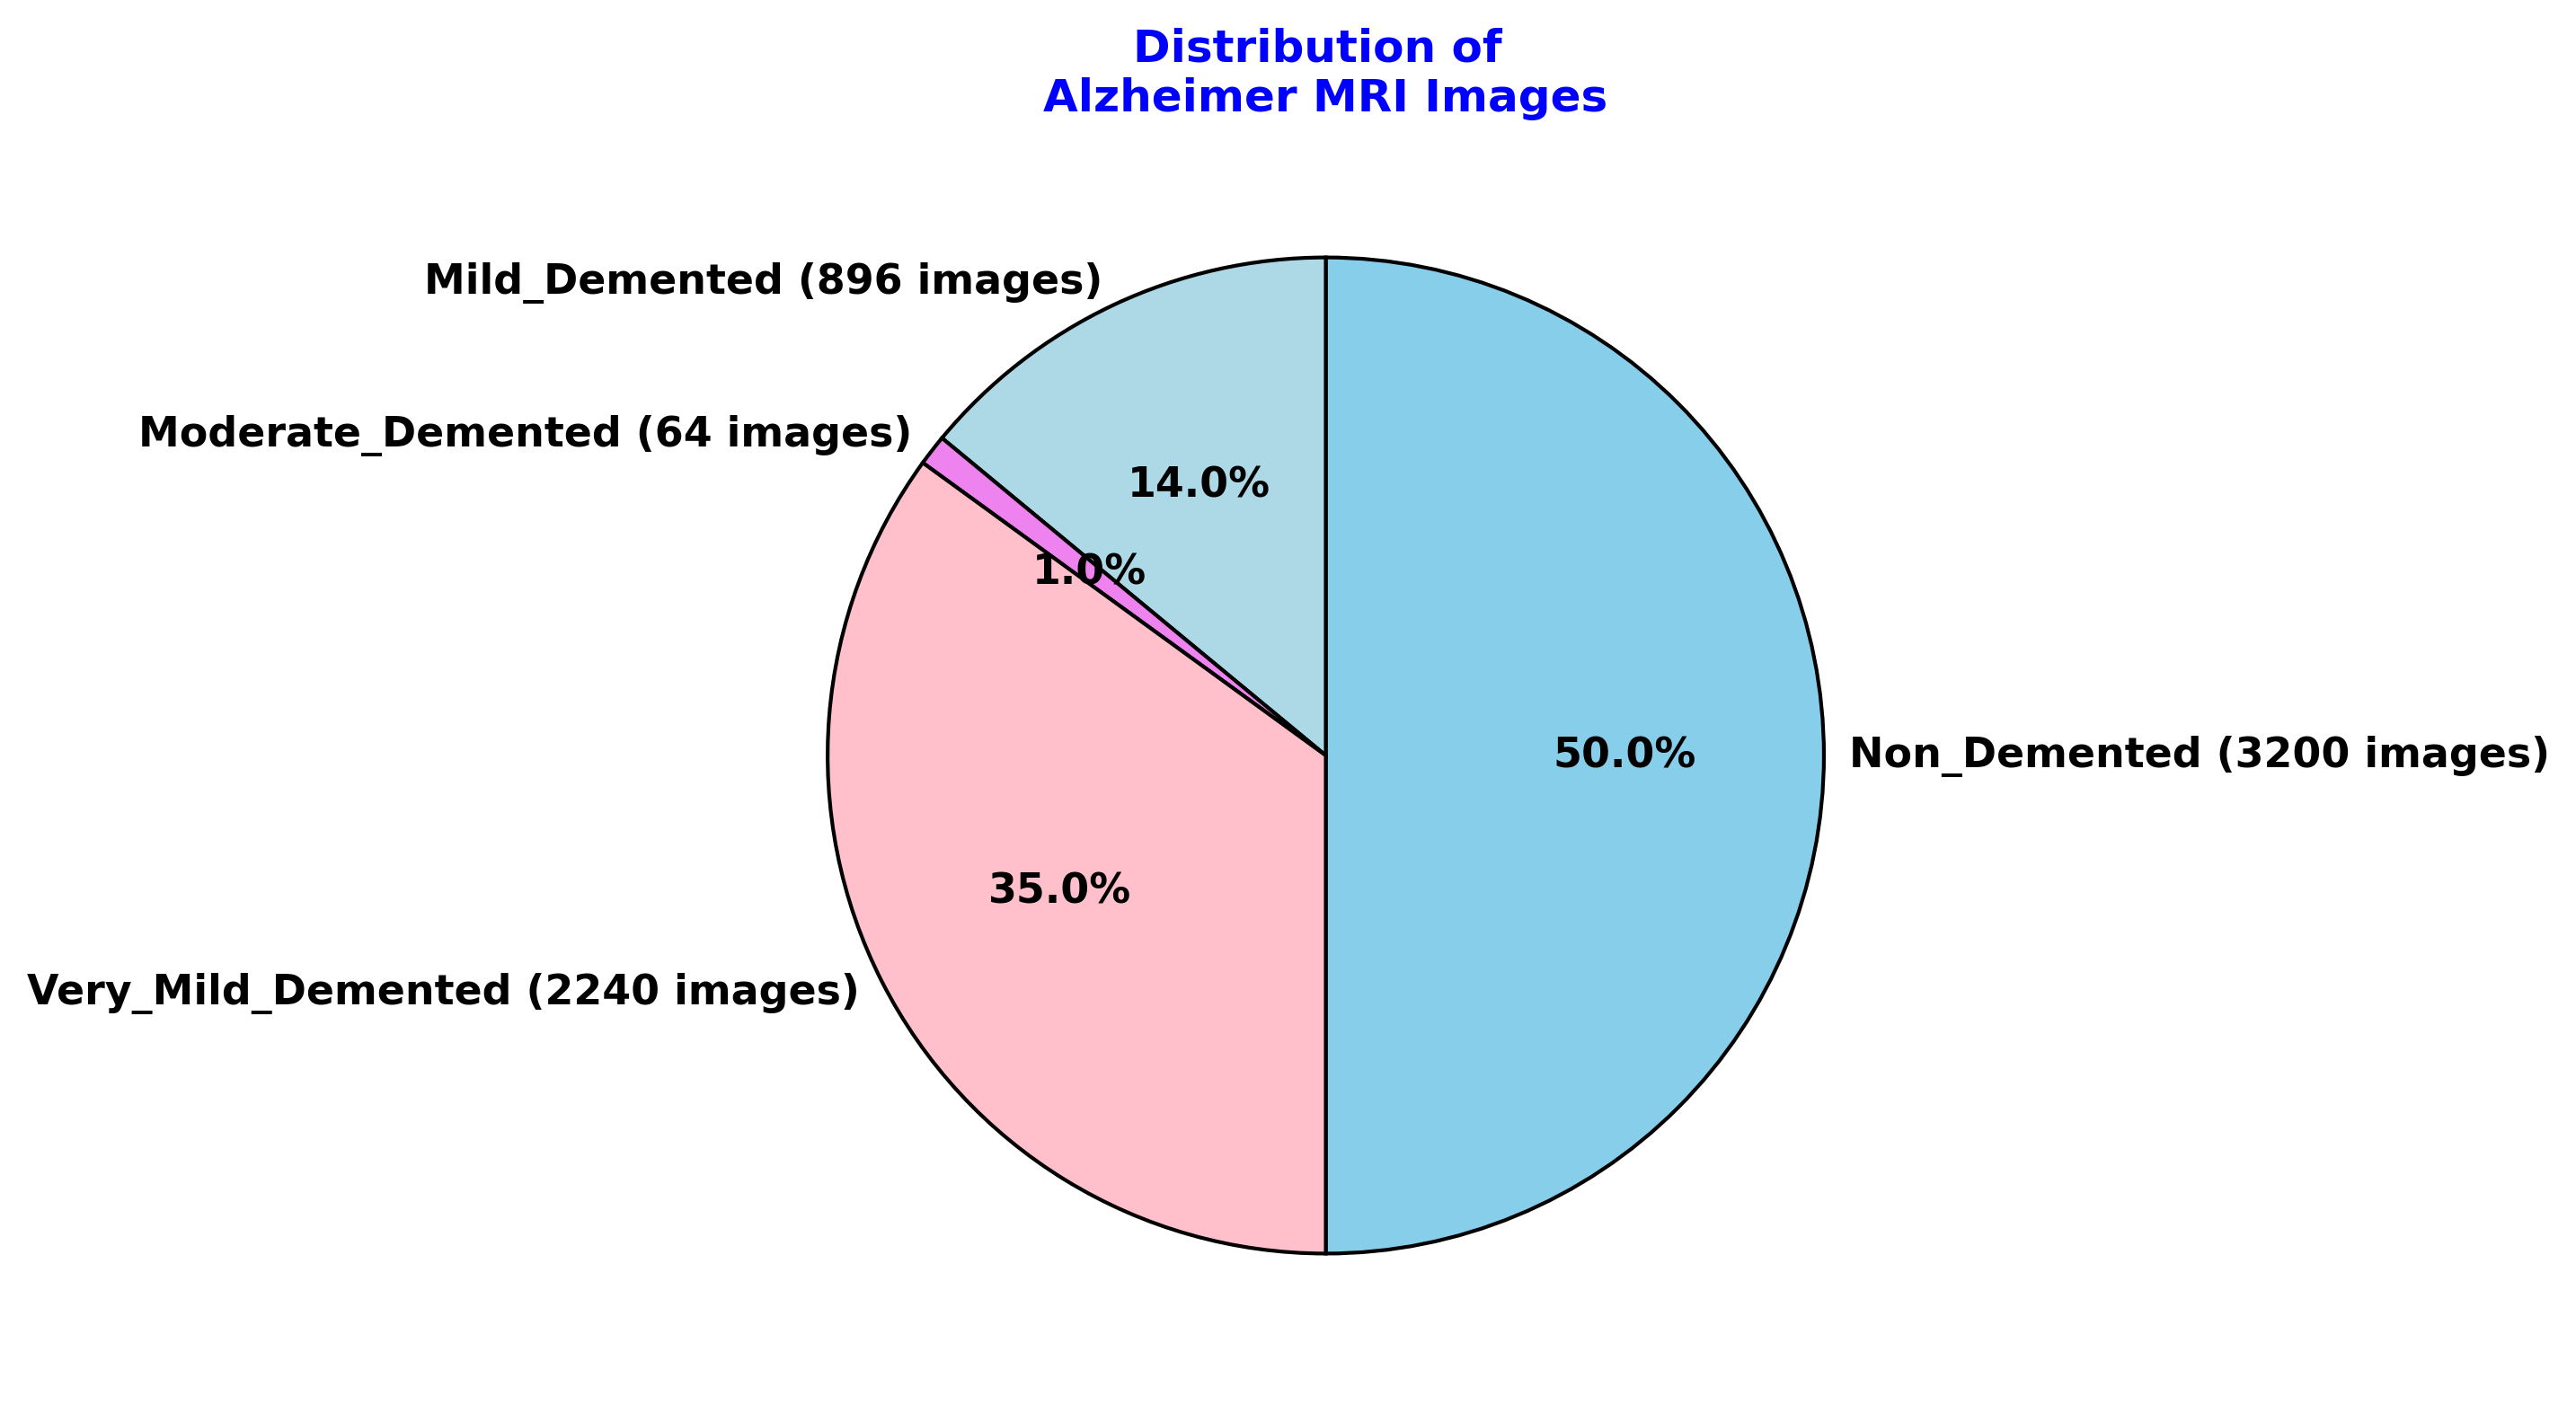

In [3]:
class_dist = {}
def image_counter(folder_path):
    basename = os.path.basename(folder_path)
    print('\033[92m'+f"A search has been initiated within the folder named '{basename}'."+'\033[0m')
    image_extensions = ['.jpg', '.jpeg', '.png']

    for root, dirs, _ in os.walk(folder_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            count = 0

            for filename in os.listdir(dir_path):
                file_ext = os.path.splitext(filename)[1].lower()

                if file_ext in image_extensions:
                    count += 1

            class_dist[dir_name] = count
            print(f"There are \033[35m{count}\033[0m images in the {dir_name} folder.")
    print('\033[92m'+"The search has been completed."+'\033[0m')

    keys = list(class_dist.keys())
    values = list(class_dist.values())
    explode = (0.1,)*len(keys)

    labels = [f'{key} ({value} images)' for key, value in zip(keys, values)]

    plt.pie(values, labels=labels, autopct='%1.1f%%',
            shadow=False, startangle=-90, colors=["skyblue", "lightblue", "violet", "pink"], textprops={'fontsize': 11, "fontweight" : "bold", "color":"black"},  wedgeprops=
           {'edgecolor':'black'} , labeldistance=1.05)
    plt.title("Distribution of \nAlzheimer MRI Images", size=12, fontweight="bold", color="blue")

PATH = '/kaggle/input/alzheimer-mri-dataset/Dataset'

image_counter(PATH)

In [4]:
data = tf.keras.utils.image_dataset_from_directory(PATH,
                                                batch_size = 32,
                                                image_size=(128, 128),
                                                shuffle=True,
                                                seed=42,)
class_names = data.class_names

Found 6400 files belonging to 4 classes.


Min and max pixel values in the batch -> 0.0 & 1.0


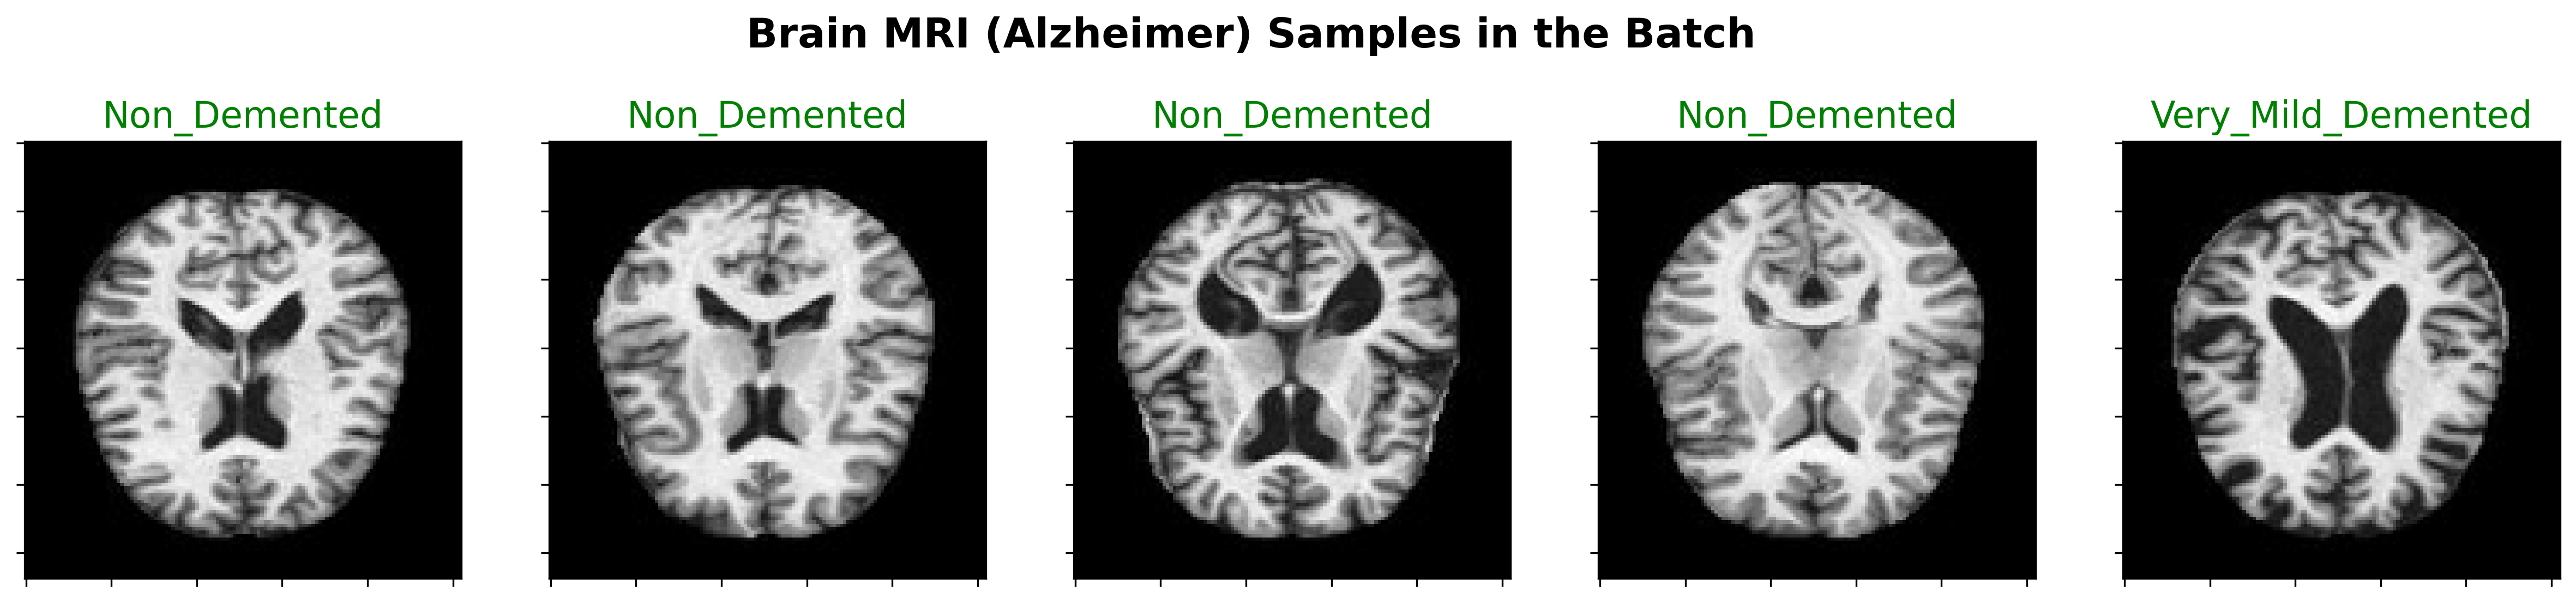

In [5]:
alz_dict = {index: img for index, img in enumerate(data.class_names)}

class Process:
    def __init__(self, data):
        self.data = data.map(lambda x, y: (x/255, y))

    def create_new_batch(self):
        self.batch = self.data.as_numpy_iterator().next()
        text = "Min and max pixel values in the batch ->"
        print(text, self.batch[0].min(), "&", self.batch[0].max())

    def show_batch_images(self, number_of_images=5):
        fig, ax = plt.subplots(ncols=number_of_images, figsize=(20,20), facecolor="white")
        fig.suptitle("Brain MRI (Alzheimer) Samples in the Batch", color="black",fontsize=18, fontweight='bold', y=0.6)
        for idx, img in enumerate(self.batch[0][:number_of_images]):
            ax[idx].imshow(img)
            class_no = self.batch[1][idx]
            ax[idx].set_title(alz_dict[class_no], color="green", fontsize=16)
            ax[idx].set_xticklabels([])
            ax[idx].set_yticklabels([])

    def train_test_val_split(self, train_size, val_size, test_size):

        train = int(len(self.data)*train_size)
        test = int(len(self.data)*test_size)
        val = int(len(self.data)*val_size)

        train_data = self.data.take(train)
        val_data = self.data.skip(train).take(val)
        test_data = self.data.skip(train+val).take(test)

        return train_data, val_data, test_data
process = Process(data)
process.create_new_batch()
process.show_batch_images(number_of_images=5)

In [6]:
train_data, val_data, test_data= process.train_test_val_split(train_size=0.8, val_size=0.1, test_size=0.1)
y_train = tf.concat(list(map(lambda x: x[1], train_data)), axis=0)
class_weight = compute_class_weight('balanced',classes=np.unique(y_train), y=y_train.numpy())
class_weights = dict(zip(np.unique(y_train), class_weight))

In [7]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
def build_model():
    base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(128,128,3))
    for layer in base_model.layers:
        layer.trainable = False
    
    input_layer = Input(shape=(128, 128, 3))
    x = base_model(input_layer)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(2048, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1028, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    output = Dense(4, activation='softmax')(x)
    model = Model(input_layer, output)
    
    optimizer = keras.optimizers.Adam(learning_rate=0.00001)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    model.summary()
    return model

model = build_model()
def checkpoint_callback():
    checkpoint_filepath = '/tmp/checkpoint/model_checkpoint.keras'

    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        save_freq='epoch',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    return model_checkpoint_callback

def early_stopping(patience):
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
    return es_callback

checkpoint_callback = checkpoint_callback()
early_stopping = early_stopping(patience=5)
callbacks = [checkpoint_callback, early_stopping]

EPOCHS = 100
history = model.fit(train_data, epochs = EPOCHS, validation_data = val_data, class_weight = class_weights)

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet169 (Functional)        │ (None, 4, 4, 1664)     │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 26624)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26624)          │       106,496 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │    54,528,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1028)           │     2,106,372 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1028)           │         4,112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       526,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,924,952 (266.74 MB)

 Trainable params: 57,222,672 (218.29 MB)

 Non-trainable params: 12,702,280 (48.46 MB)

Epoch 1/100
  2/160 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.1953 - loss: 1.6623    

I0000 00:00:1712830002.274961     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712830002.357234     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2181 - loss: 1.9521

W0000 00:00:1712830024.965819     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 68s 147ms/step - accuracy: 0.2182 - loss: 1.9515 - val_accuracy: 0.4953 - val_loss: 1.1697
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.3094 - loss: 1.3159 - val_accuracy: 0.5625 - val_loss: 0.9979
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.4193 - loss: 1.0697 - val_accuracy: 0.6391 - val_loss: 0.8538
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.4872 - loss: 0.9657 - val_accuracy: 0.6703 - val_loss: 0.7954
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.5427 - loss: 0.8421 - val_accuracy: 0.7063 - val_loss: 0.7031
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.5912 - loss: 0.7442 - val_accuracy: 0.7422 - val_loss: 0.6318
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.6028 - loss: 0.7254 - val_accuracy: 0.7781 - val_loss: 0.5605
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.6411 - loss: 0.6228 - val_accu

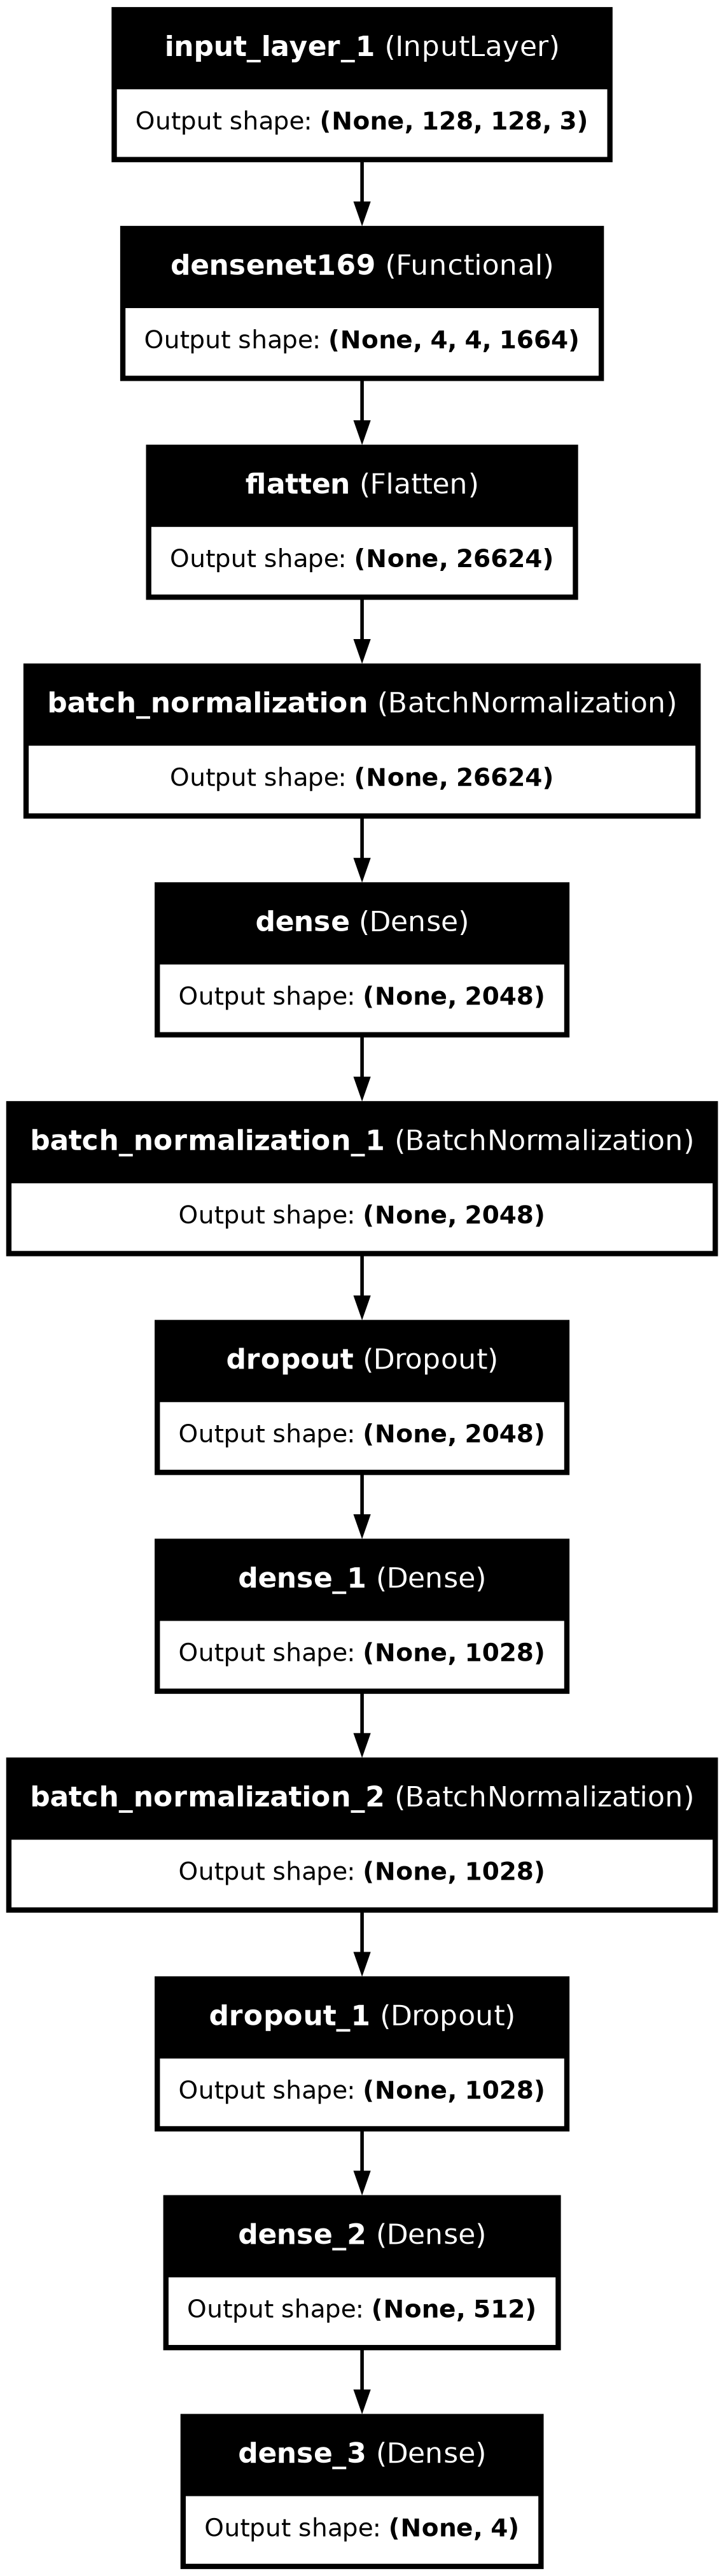

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

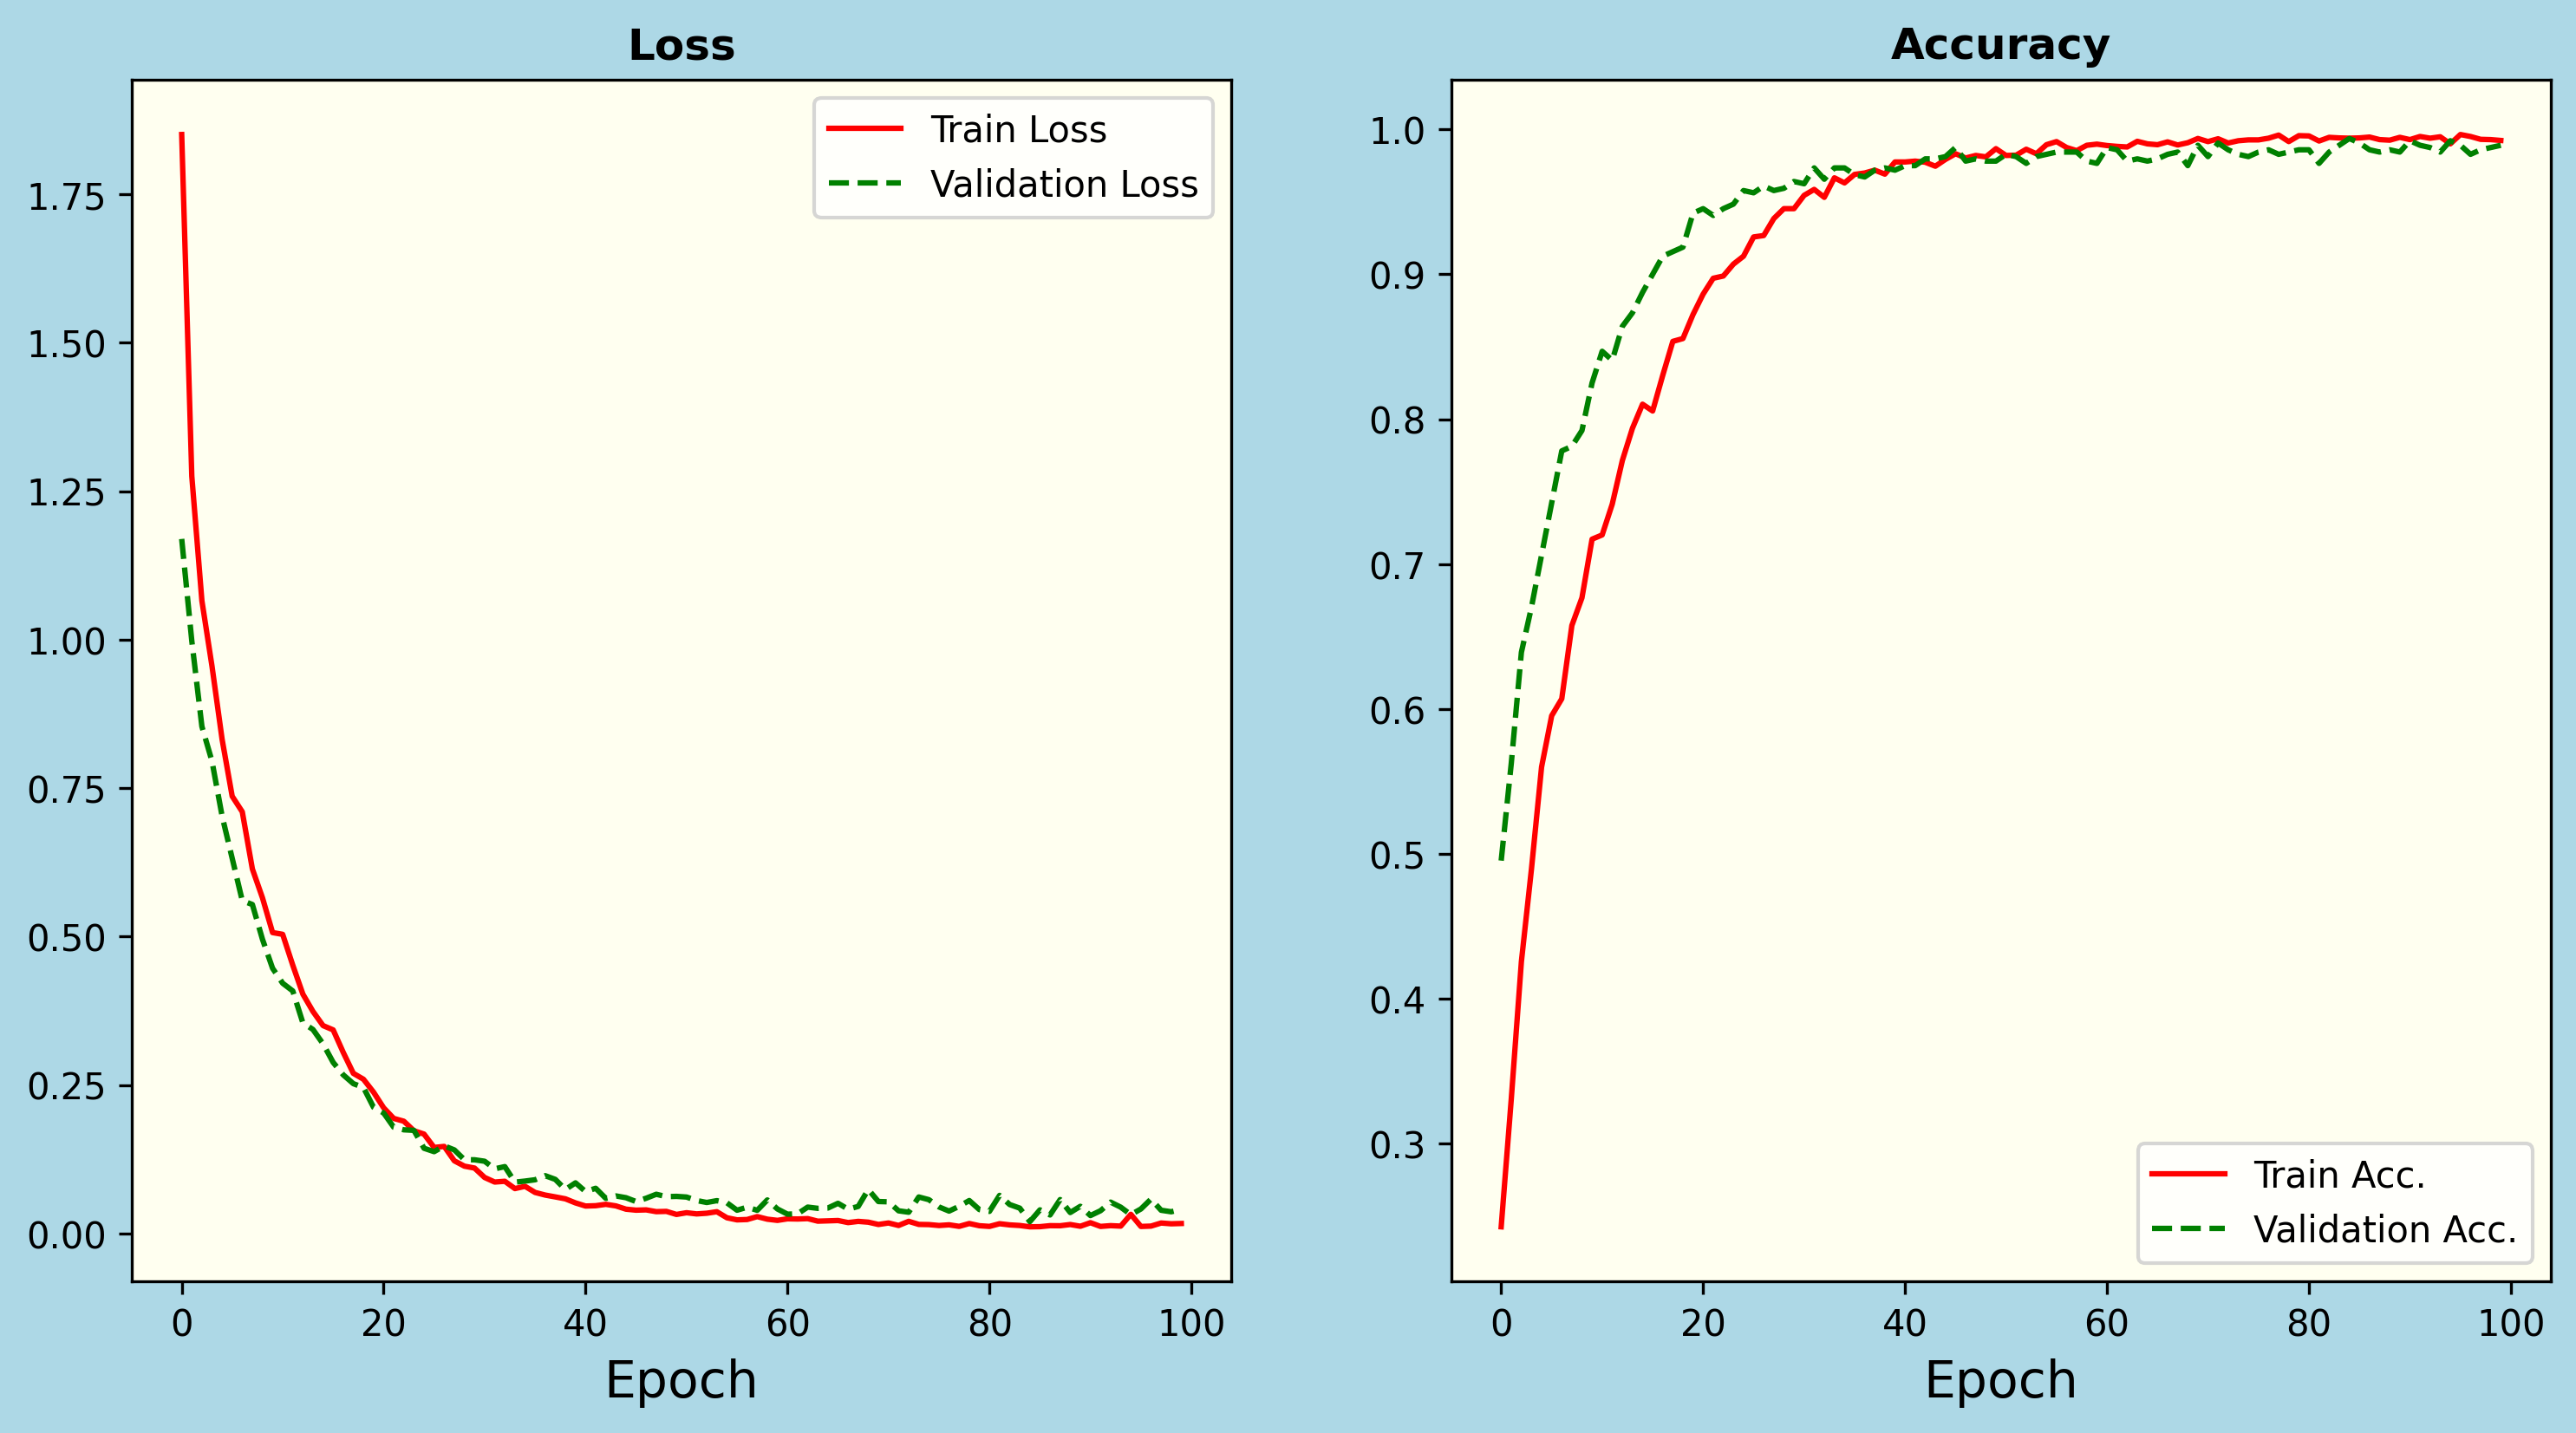

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), facecolor="lightblue")
ax[0].set_facecolor('ivory')
ax[0].set_title('Loss', fontweight="bold")
ax[0].set_xlabel("Epoch", size=14)
ax[0].plot(history.epoch, history.history["loss"], label="Train Loss", color="red")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss", color="green", linestyle="dashed")
ax[0].legend()
ax[1].set_facecolor('ivory')
ax[1].set_title('Accuracy', fontweight="bold")
ax[1].set_xlabel("Epoch", size=14)
ax[1].plot(history.epoch, history.history["accuracy"], label="Train Acc.", color="red")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Acc.", color="green", linestyle="dashed")
ax[1].legend()

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9743 - loss: 0.0991


W0000 00:00:1712831467.025563     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


                    precision    recall  f1-score   support

     Mild_Demented    0.97647   0.94318   0.95954        88
 Moderate_Demented    0.80000   1.00000   0.88889         4
      Non_Demented    0.98113   0.98423   0.98268       317
Very_Mild_Demented    0.96983   0.97403   0.97192       231

          accuracy                        0.97500       640
         macro avg    0.93186   0.97536   0.95076       640
      weighted avg    0.97528   0.97500   0.97503       640



Text(286.1666666666666, 0.5, 'True')

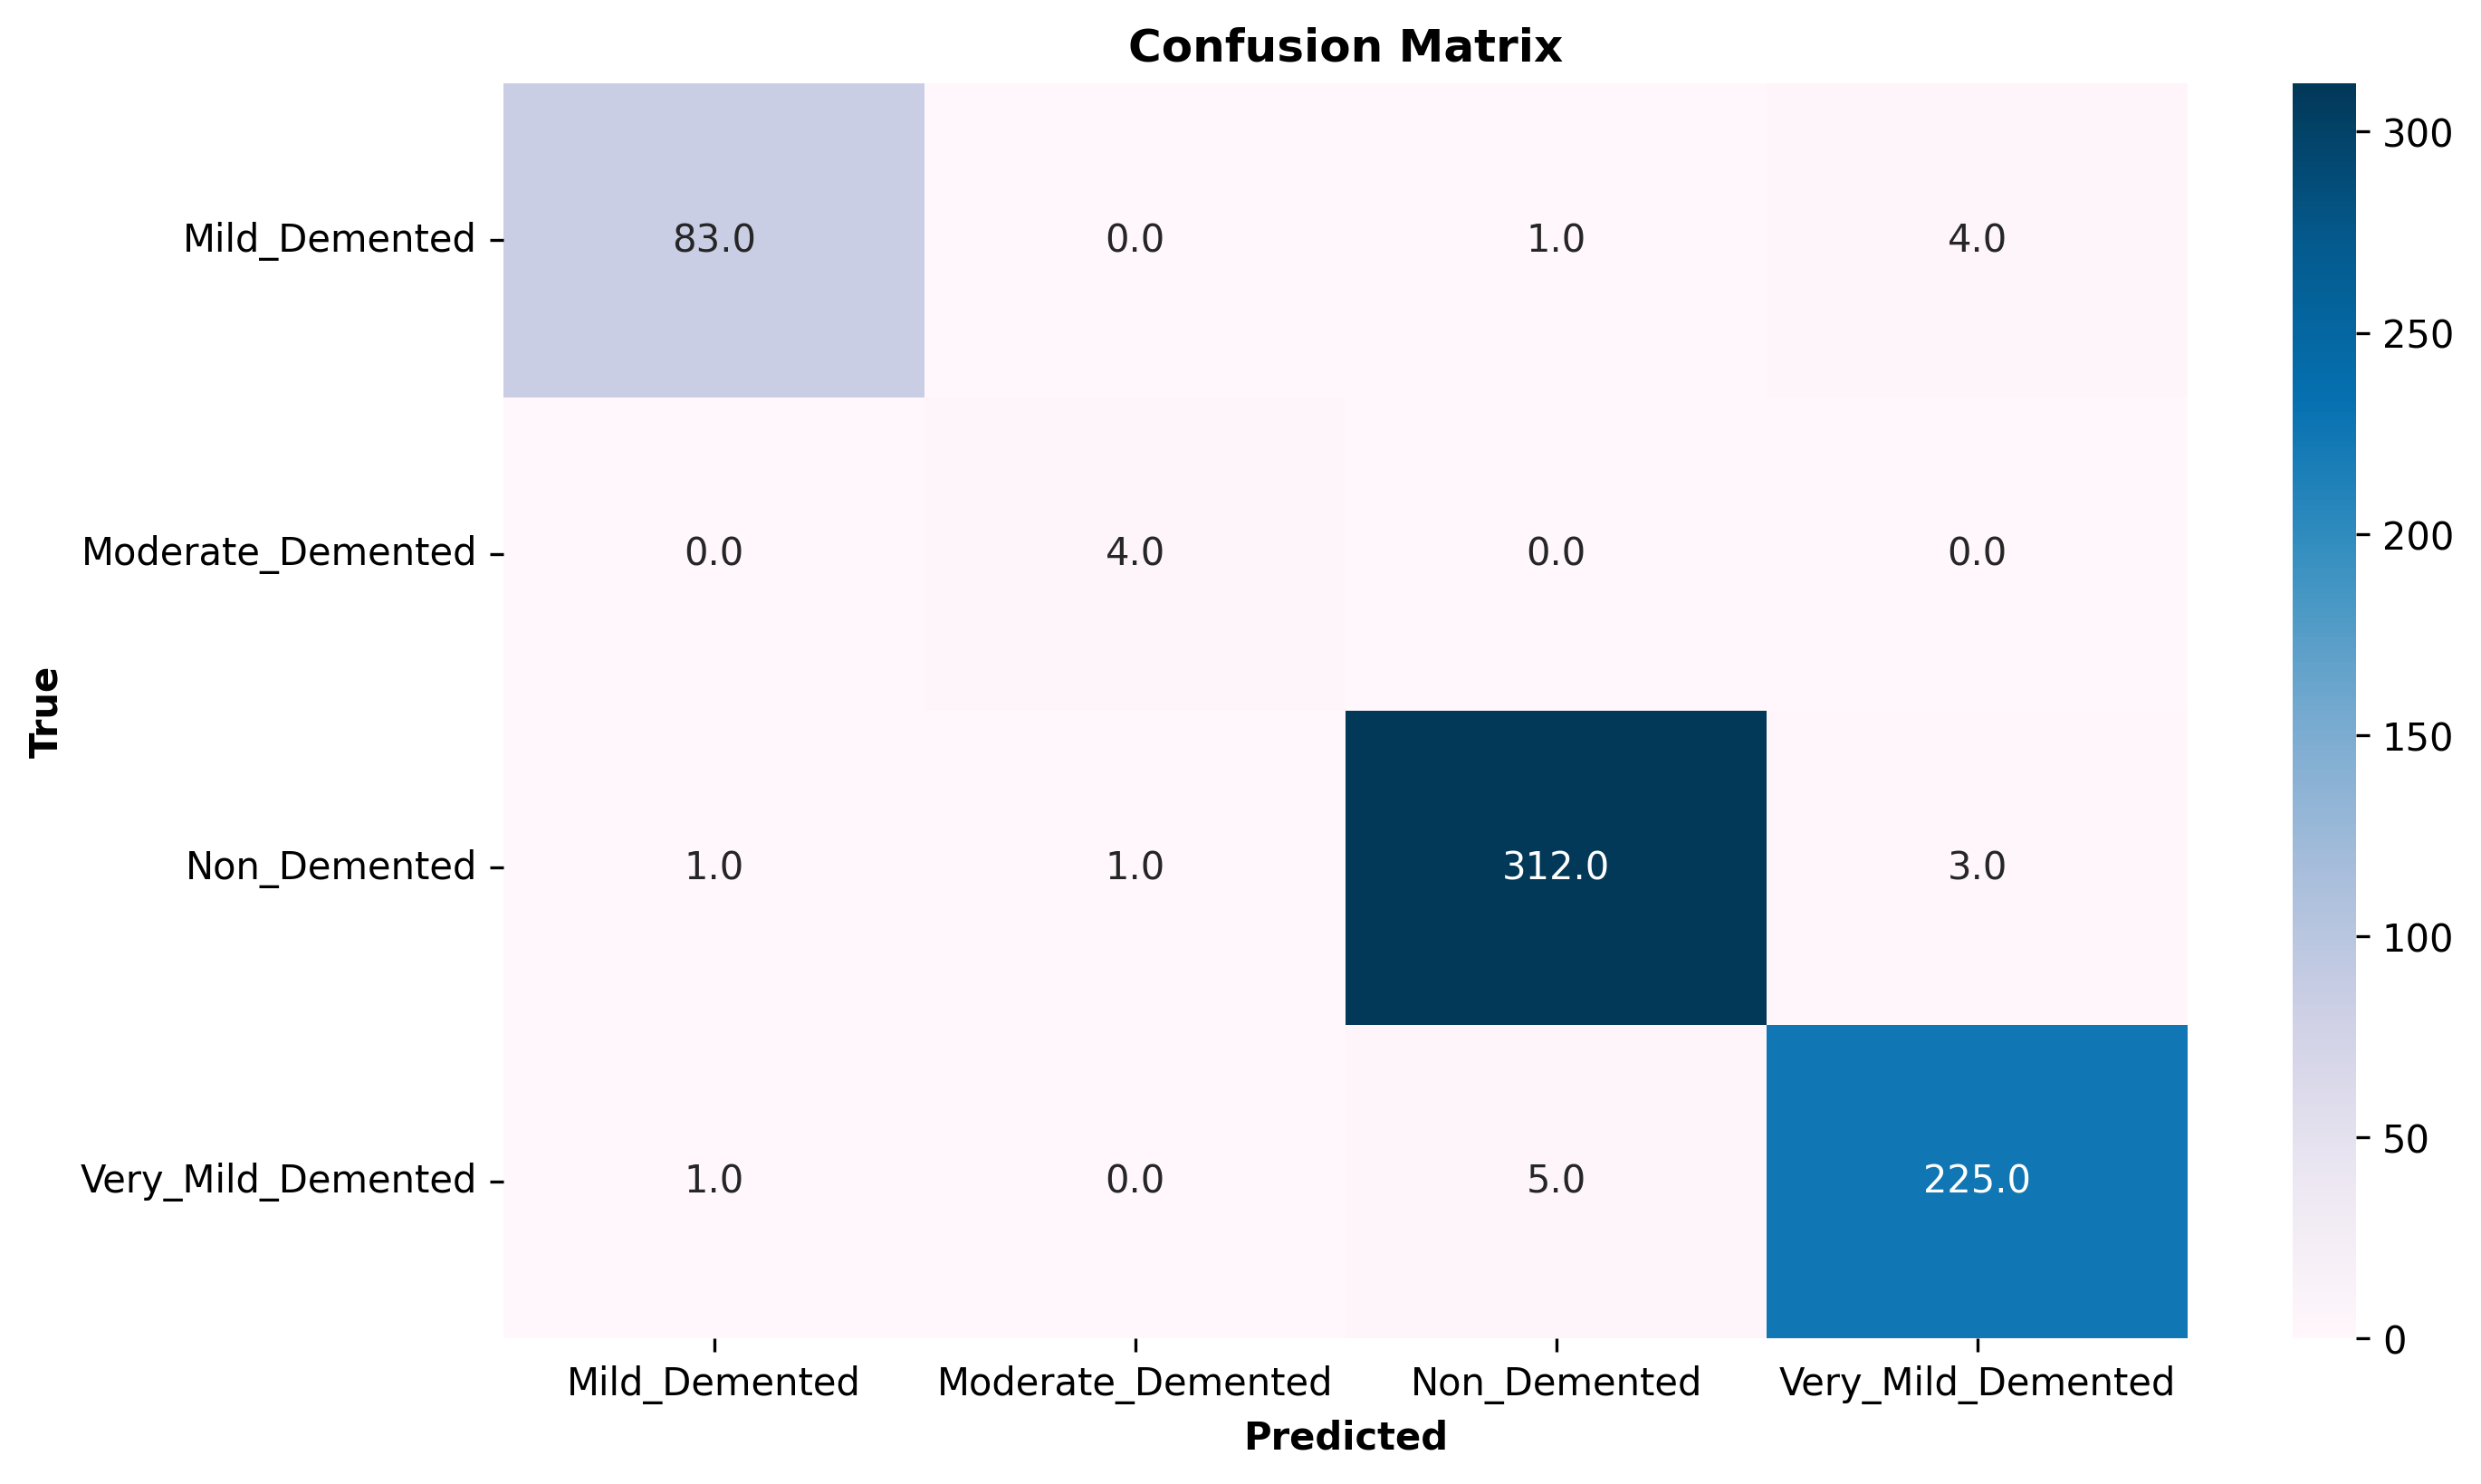

In [10]:
model.evaluate(test_data)

predictions = []
labels = []

for X, y in test_data.as_numpy_iterator():
    y_pred = model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)

predictions = np.array(predictions)
labels = np.array(labels)

print(classification_report(labels, predictions, target_names=class_names, digits = 5))

cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df
plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="PuBu", fmt=".1f")
plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")